In [2]:
import numpy as np 
import matplotlib.pyplot as plt

# Torch
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import WeightedRandomSampler
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchsummary import summary

# Save/Load as mat.
from scipy.io import savemat, loadmat
import h5py
import mat73 # https://github.com/skjerns/mat7.3

# Progress Bar
from rich.progress import track
from rich.progress import Progress

# Other
import argparse
import multiprocessing as mp
import os
import scipy.signal as signal
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns
from plot import *

# User-defined
from mat2np_segment_all_subject import *
from dsp_preprocess import *
from dataset_parser import *
from models import *
from feature_extractor import *
from set_args import *
from train_test_process import *
from vit import *

In [95]:
# ===================== Filter =====================
def butter_filter(x, type_filter="highpass", cut_low=20, cut_high = 500, fs=2000, order=4):
    nyq = 0.5 * fs
    if type_filter=="bandpass":
        normal_cut_low = [cut_low / nyq, cut_high / nyq]
    else:
        normal_cut_low = cut_low / nyq
    sos = signal.butter(N=order, Wn=normal_cut_low, btype=type_filter, output='sos')
    # y = signal.sosfilt(sos, x)
    y = signal.sosfiltfilt(sos,x,axis=0)
    return y

def filter(x, type_filter="none", cut_low=20, cut_high = 200, fs=2000, order=5):
    if type_filter != 'none':
        type_filter_name, cut_low, cut_high = type_filter.split('_')
    else:
        type_filter_name = "none"

    if type_filter_name == "none":
        y = x
    elif type_filter_name == "HPF":
        y = butter_filter(x, type_filter="highpass", cut_low=float(cut_low), fs=fs, order=order)
    elif type_filter_name == "LPF":
        y = butter_filter(x, type_filter="lowpass", cut_low=float(cut_low), fs=fs, order=order)
    elif type_filter_name == "BPF":
        y = butter_filter(x, type_filter="bandpass", cut_low=float(cut_low), cut_high=float(cut_high), fs=fs, order=order)
    else:
        raise TypeError(f'{type_filter} is not defined in type_filter')
    return y

In [109]:
def dataset_filter_normalize_segementation(fileName, order, fs=2000, window_size = 400, window_step=200, num_channel=12, type_filter="BPF_20_200", type_norm="mvc"):
    gesture_label  = np.array(int(fileName.split('/')[-1].split('.')[0].split('_')[1]))
    emg_sample = np.load(fileName)

    # Filtering and Normalization
    emg_sample_filter = filter(emg_sample,type_filter=type_filter, fs=fs, order=order)    # whole_window_size * num_channel (e.g., LPF_200_, HPF_20_, ...)
    emg_sample_filter_norm = normalization(emg_sample_filter, type_norm=type_norm)

    # Sliding window segmentation
    num_window = (np.floor((emg_sample_filter_norm.shape[0]-window_size)/window_step) + 1).astype(int)
    emg_sample_filter_norm_seg_batch = None
    gesture_label_batch = None
    # emg_sample_filter_norm_seg_batch = np.zeros((num_window, window_size, num_channel))
    # gesture_label_batch = np.zeros((num_window, 1))

    for i in range(num_window):
        emg_sample_filter_norm_seg = emg_sample_filter_norm[i*window_step:i*window_step+window_size]
        emg_sample_filter_norm_seg_batch = handle_concatenation(emg_sample_filter_norm_seg_batch, emg_sample_filter_norm_seg.reshape(1,window_size,-1), axis=0)
        gesture_label_batch = handle_concatenation(gesture_label_batch, gesture_label.reshape(1,-1), axis=0)
        
        # num_sample = emg_sample_filter_norm_seg.shape[0]
        # emg_sample_filter_norm_seg_batch[i] = emg_sample_filter_norm_seg
        # gesture_label_batch[i] = gesture_label

    return emg_sample_filter_norm_seg_batch, gesture_label_batch  #shape: (num_window, window_size, num_channel); #shape: (num_window,1)

In [118]:
idx_subject = 1
idx_exercise = 1
idx_trial = 1

PATH_seg_np = "Dataset/DB2/DB2_np/DB2_s_{}/exercise_{}/trial_{}/".format(idx_subject,idx_exercise,idx_trial)
fileNames = sorted([PATH_seg_np+i for i in os.listdir(PATH_seg_np)])
# print(sorted(fileNames))
mean_all_gesture = 0
for fileName in fileNames:
    gesture = fileName.split("/")[-4:]
    emg_sample_dataset, gesture_label_dataset = dataset_filter_normalize_segementation(fileName, 3, fs=2000, window_size = 400, window_step=200, num_channel=12, type_filter="none", type_norm="none")
    emg_sample_dataset_LPF1, _ = dataset_filter_normalize_segementation(fileName, 1 ,fs=2000, window_size = 400, window_step=200, num_channel=12, type_filter="LPF_20_", type_norm="mu_law_0.1")
    emg_sample_dataset_LPF3, _ = dataset_filter_normalize_segementation(fileName, 1 ,fs=2000, window_size = 400, window_step=200, num_channel=12, type_filter="LPF_20_", type_norm="mu_law_1")
    emg_sample_dataset_LPF5, _ = dataset_filter_normalize_segementation(fileName, 1 ,fs=2000, window_size = 400, window_step=200, num_channel=12, type_filter="LPF_20_", type_norm="mu_law_256")
    amp_mean = np.mean(np.mean(abs(emg_sample_dataset),axis=1), axis=0)
    # print(amp_mean)
    # print(f"{gesture[-1]}, Mean: {np.mean(amp_mean)}, Max amplitude: {np.max(emg_sample_dataset)}")
    mean_all_gesture += np.mean(amp_mean)
    # plt.figure(figsize=(6,2))
    # plt.hist(abs(emg_sample_dataset.reshape(-1)))
    
    # print(emg_sample_dataset.shape)
    # plt.figure(figsize=(6,2))
    # plt.plot(emg_sample_dataset[0])
    # plt.title(gesture)
print(f"{PATH_seg_np} mean: {mean_all_gesture/len(fileNames)}")

Dataset/DB2/DB2_np/DB2_s_1/exercise_1/trial_1/ mean: 3.314649438834749e-05


In [125]:
a = [[1,2,3],[4,5,6]]
print(len(a))
print(len(a[0]))

2
3


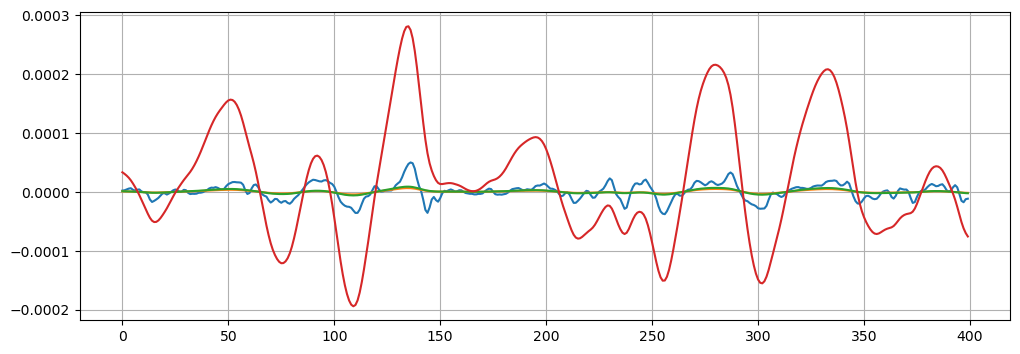

In [120]:
plt.figure(figsize=(12,4))
plt.plot(emg_sample_dataset[0,:,0])
plt.plot(emg_sample_dataset_LPF1[0,:,0])
plt.plot(emg_sample_dataset_LPF3[0,:,0])
plt.plot(emg_sample_dataset_LPF5[0,:,0])
plt.grid()


In [ ]:
# idx_subject = 40
# idx_exercise = 3
# idx_trial = 5

for idx_subject in range(1,41):
    for idx_trial in range(1,7):
        for idx_exercise in range(1,4):
            PATH_seg_np = "Dataset/DB2/DB2_np/DB2_s_{}/exercise_{}/trial_{}/".format(idx_subject,idx_exercise,idx_trial)
            fileNames = sorted([PATH_seg_np+i for i in os.listdir(PATH_seg_np)])
            # print(sorted(fileNames))
            mean_all_gesture = 0
            for fileName in fileNames:
                gesture = fileName.split("/")[-4:]
                emg_sample_dataset, gesture_label_dataset = dataset_filter_normalize_segementation(fileName, fs=2000, window_size = 400, window_step=200, num_channel=12, type_filter="none", type_norm="none")
                amp_mean = np.mean(np.mean(abs(emg_sample_dataset),axis=1), axis=0)
                # print(amp_mean)
                # print(f"{gesture[-1]}, Mean: {np.mean(amp_mean)}, Max amplitude: {np.max(emg_sample_dataset)}")
                mean_all_gesture += np.mean(amp_mean)
                # plt.figure(figsize=(6,2))
                # plt.hist(abs(emg_sample_dataset.reshape(-1)))
                
                # print(emg_sample_dataset.shape)
                # plt.figure(figsize=(6,2))
                # plt.plot(emg_sample_dataset[0])
                # plt.title(gesture)
            print(f"{PATH_seg_np} mean: {mean_all_gesture/len(fileNames)}")

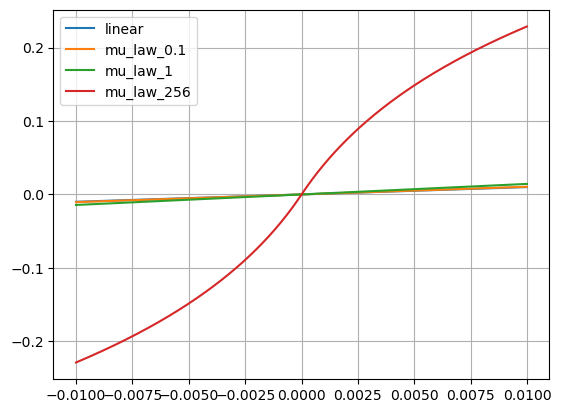

In [5]:
# ===================== Normalization =====================
def normalization(x, type_norm="mu_law"):
    # input x : numpy, shape: (window_size, num_channel)
    # output y: numpy, shape: (window_size, num_channel)

    if type_norm == "none":
        y = x
    elif type_norm == "mvc":    #  maximum voluntary contraction (MVC)
        # mvc = 0.002479567551179044 # search over all train dataset (current MVC: 4.088872887106668)
        mvc = 1e-5
        y = x/mvc
    elif type_norm == "standardization":
        mean = np.mean(x,axis=0)
        std = np.std(x,axis=0)
        y = (x-mean)/std
    elif type_norm == "min_max":
        min_val = np.min(x, axis=0)
        max_val = np.max(x, axis=0)
        y = (x - min_val)/(max_val-min_val)
    elif "mu_law" in type_norm:
        temp = type_norm.split("_")
        mu = float(temp[-1])
        y = np.sign(x)*(np.log(1+mu*abs(x)))/(np.log(1+mu))
    else:
        raise TypeError(f'{type_norm} is not defined in type_norm')

    return y

x = np.arange(-0.01,0.01,0.00001)

algo = ["linear","mu_law_0.1","mu_law_1","mu_law_256"]
y1 = normalization(x, type_norm=algo[1])
y2 = normalization(x, type_norm=algo[2])
y3 = normalization(x, type_norm=algo[3])

plt.Figure(figsize=(4,4))
plt.plot(x,x)
plt.plot(x,y1)
plt.plot(x,y2)
plt.plot(x,y3)
plt.grid()
plt.legend(algo)